# DATA PROCESSING 

This Jupyter notebook contains the detailed code to read, clean and process a GPX file with the GPS data of an individual trajectory. 

**1. Read the original GPX file**. We Open the .gpx file as a Data-Frame.
    
    
**2. Plot the trajectory**. We represent the original trajectory on a map with the street network 
    
    
**3. Processing the trajectory**. We perform some simple data filtering/cleaning (noise) procedures and more advanced processing where we calculate some basic features such as time difference, distance, speed, orientation and change of orientation between consecutive GPS locations. We also label each GPS record as stop or moving.
   
       3.1. Cleaning noisy records at the beginning/end of the trajectory.
   
       3.2. Time difference, distance and instantaneous velocity between GPS records.
   
       3.3. Orientation and reorientation.
   
       3.4. Detecting stops.
   
 
**4. Save processed data-set**. We save the processed trajectory in a .csv file

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------





#  1. Read the original GPX file

- Read the .gpx file (which must be located at the same folder as this Notebook).
- Convert it into a DataFrame.

In [1]:
from gpxcsv import gpxtolist   # Library to read .gpx files
import pandas as pd     # Pandas library for Dataframe
import numpy as np  # Numpy for operations
from shapely.geometry import Point, LineString, Polygon   # For geometries
import networkx as nx   # Operations with networks
import osmnx as ox  # OpenStreetMaps to obtain urban street networks and  map visualisation
import matplotlib.pyplot as plt   # Plot
from math import sin, cos, sqrt, atan2, radians
import math

name = 'original data\\g5.gpx'
df = pd.DataFrame(gpxtolist(name))    # Read the .gpx file as a DataFrame
df

,lat,lon,name,cmt,desc,ele,time
0,41.602587,2.283500,G5,G5,G5,136.829,2022-04-30T11:14:02Z
1,41.602611,2.283435,G5,G5,G5,137.400,2022-04-30T11:14:04Z
2,41.602610,2.283367,G5,G5,G5,137.920,2022-04-30T11:14:07Z
3,41.602614,2.283305,G5,G5,G5,137.909,2022-04-30T11:14:10Z
4,41.602634,2.283249,G5,G5,G5,137.953,2022-04-30T11:14:27Z
...,...,...,...,...,...,...,...
163,41.604245,2.282163,G5,G5,G5,143.579,2022-04-30T12:36:03Z
164,41.604282,2.282199,G5,G5,G5,143.545,2022-04-30T12:36:26Z
165,41.604245,2.282159,G5,G5,G5,143.642,2022-04-30T12:39:09Z
166,41.604281,2.282122,G5,G5,G5,143.727,2022-04-30T12:39:42Z


# 2. Plot the trajectory 

- Display the trajectory on a map. This is useful to have a first picture of the trip and to identify possible outliers in the GPS locations that need to be cleaned up (for instance some noisy records may appear at the beginning of the journey due to the GPS connection with the satellites, or when we are inside a building).

- We first create a function that given 4 GPS points (lat,lon), it creates the corresponding map street network (polygon).

- Then we plot the trajectory (scattering the GPS recorded locations) on the map.

In [30]:
def map_network(lon1,lat1,lon2,lat2,lon3,lat3,lon4,lat4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    NOTE THAT THE GPS COORDS. MUST BE PROVIDED BY FIRST INDICATING THE LONGITUDE AND THEN THE LATITUDE (AS OPPOSED TO THE
    COORDINATES GIVEN GY GOOGLEMAPS WHEN SELECTING A PLACE, FOR EXAMPLE.)
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates). From GoogleMaps for example
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lon1,lat1), (lon2,lat2),(lon3,lat3),(lon4,lat4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    
    # Create the figure from the graph. The graph is composed by the edges (streets) and the nodes (street intersections).
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.7, node_size=0)
    
    # We can import and plot the buildings using "tags" (also with parks, pedestrian highways, etc.)
    place_name = "Granollers, Vallès Oriental"
    place_name2 = 'Les Corts, Barcelona'
    
    tags={"building": True}
    tags_parks={"leisure": "park"}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf_parks = ox.geometries_from_place(place_name, tags_parks)
    
    gdf.plot(ax=ax,color='silver',alpha=0.5) # plot buildings
    gdf_parks.plot(ax=ax,color='darkgreen',alpha=0.2) # plot parks
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area.
    
    return fig, ax

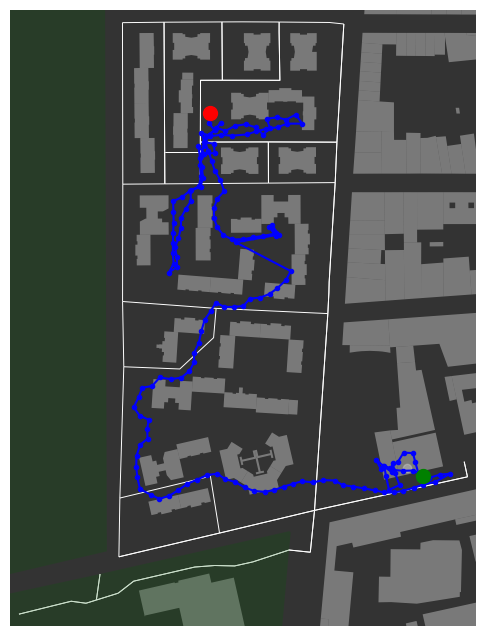

In [31]:
# Initialise the map of the district of Granollers (Primer de Maig)

#  NOTE THAT THE GPS COORDS. MUST BE PROVIDED BY FIRST INDICATING THE LONGITUDE AND THEN THE LATITUDE (AS OPPOSED TO THE
#  COORDINATES GIVEN GY GOOGLEMAPS WHEN SELECTING A PLACE, FOR EXAMPLE.)

# Barri Primer de Maig (Granollers)
lat1_granollers=41.605107921345585
lon1_granollers=2.2804419490443517

lat2_granollers=41.60183248235341
lon2_granollers=2.28054397694062

lat3_granollers=41.602065783859004
lon3_granollers=2.283748215236327

lat4_granollers=41.60530532450823
lon4_granollers=2.2840062702794897



# Palau Reial
lat1_palau_reial=41.39051274619827
lon1_palau_reial=2.120995295130168

lat2_palau_reial=41.3848189661481
lon2_palau_reial=2.1218877896916606

lat3_palau_reial=41.3833175990405
lon3_palau_reial=2.114868544114087

lat4_palau_reial=41.38867332570979
lon4_palau_reial=2.113224800622489


fig, ax = map_network(lon1_granollers, lat1_granollers, lon2_granollers, lat2_granollers, 
                      lon3_granollers, lat3_granollers, lon4_granollers, lat4_granollers)  # Generate the map

#fig, ax = map_network(lon1_palau_reial, lat1_palau_reial, lon2_palau_reial, lat2_palau_reial, 
                      #lon3_palau_reial, lat3_palau_reial, lon4_palau_reial, lat4_palau_reial)  # Generate the map

# We put the latitude and the longitude coordinates of the trajectory (dataframe) into lists
lat=df['lat'].tolist()  
lon=df['lon'].tolist()

# Display the trajectory (longitude, latitude) on the same map as the street network. 
ax.plot(lon, lat,'-o',c='blue',markersize=3) 

ax.plot(lon[0],lat[0],'o',c='green',markersize=10) # Initial point in green
ax.plot(lon[-1],lat[-1],'o',c='red',markersize=10) # Final point in red

#plt.savefig('original_route_e1.pdf',format='pdf', bbox_inches='tight')  # Save the figure in .pdf format

plt.show()



   

# 3. Processing the trajectory

- In this step the trajectory is cleaned (if it is needed) and processed by calculating some basic features (such as distances between GPS records, velocities, etc).


## 3.1. Cleaning noisy records at the beginning/end of the trajectory

- If some initial/final noisy records have to be removed, we simply cut the first XX points and the final YY points of the Data-Frame. 

- Of course, this process needs several iterations (tests) to determine the concrete index where to cut the dataset, with the help of the trajectory visualisation and the data-frame. 

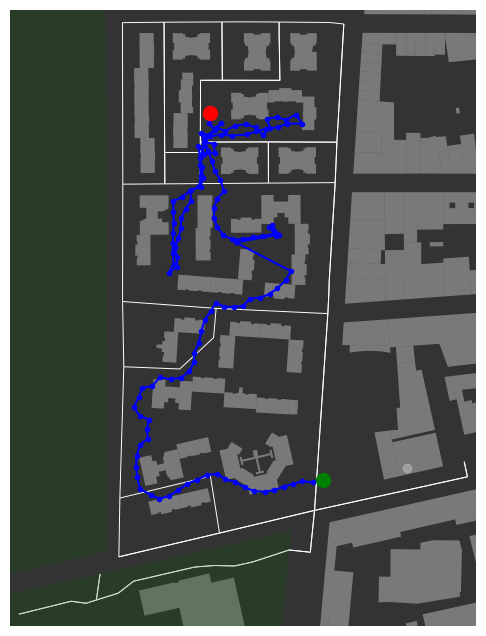

In [32]:
# Create a new Data-Frame from the index XX to the index YY of the old Data-Frame
XX=11
YY=218
df2 = df[XX:YY]

#df2 = df[XX:]  # if we only remove initial points
# df2 = df[:YY] # if we onlye remove end points


# Since we have created another Data-Frame (df2) from the index XX to YY (of df1), we have to reset the index of the new df2.
df2=df2.reset_index()  


# Finally, we can plot again the cleaned trajectory on the map

fig, ax = map_network(lon1_granollers, lat1_granollers, lon2_granollers, lat2_granollers, 
                      lon3_granollers, lat3_granollers, lon4_granollers, lat4_granollers)  # Generate the map 

# We put the latitude and the longitude coordinates of the trajectory (new dataframe) into lists
lat=df2['lat'].tolist()  
lon=df2['lon'].tolist()

# Display the trajectory (longitude, latitude) on the same map as the street network. 
ax.plot(lon, lat,'-o',c='blue',markersize=3) 

ax.plot(lon[0],lat[0],'o',c='green',markersize=10) # Initial point in green
ax.plot(lon[-1],lat[-1],'o',c='red',markersize=10) # Final point in red

#plt.savefig('cleaned_route_e1.pdf',format='pdf', bbox_inches='tight')  # Save the figure in .pdf format

plt.show()


## 3.2. Time difference, distance and instantaneous velocity between GPS records

- We obtain the time difference between consecutive timestamps, $\Delta $, which is irregular and can vary from few to large seconds (due to stops). In general, the Wikiloc app. collects data every 5s on average when the device is moving. The time-difference at the location $(t)$ is defined as the time difference between records at $(t)$ and at $(t+\Delta )$:

$$ \Delta (t) = T(t+\Delta) - T(t)$$




- We also obtain the distance in metres between consecutive GPS locations (lat,lon). There are two ways to operate: 
    1. Using the Harvesine formula, which operates with the latitude and longitude in radians and takes into account the curvature of the Earth. 
    2. Projecting the coordinates into a plane and work with Euclidean distance. (For instance, UTM Projection). 
    
    $$d(t) = \vert \vec{r}(t+\Delta (t)) - \vec{r} (t) \vert$$
    
    
- With $d(t)$ and $\Delta (t)$, we can thus compute the instantaneous velocity at (t) as:

$$v(t) = \frac{d(t)}{\Delta(t)}$$

####  Time difference $\Delta (t)$

In [9]:
def time_diff(df2):
    """ Function that given a Data-Frame with the a timestamp column, it returns the time difference between consecutive 
        timestamps. The calculation is done in an advanced-way, that is, the time difference at the location (i) is the time 
        difference between the timestamps at locations (i+1) and (i). Therefore, the last element is NaN.
    
    Inputs:
        - The Data-Frame, with the time-stamp column
        
    Outputs:
        - The Data-Frame, with a new column corresponding to the time difference between consecutive timestamps.
        
    """

    df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%dT%H:%M:%S%z')  # Correct format for the time (datetime)
    time=df2['time'].tolist()  # Time to list


    # TIME DIFFERENCE BETWEEN CONSECTUVIE GEOLOCATIONS
    diff_time=[]
    for i in range(1,len(df2['time'])):
        diff=time[i]-time[i-1]
        diff_time.append(diff)

    
    # Obviuosly, if there are N times, there will be N-1 times differences. So we need to add a NaN value at the end of 
    # the list to store it as a new column of the DataFrame. 
    diff_time.insert(len(diff_time), np.nan)  

    df2['At']=diff_time   # Store it as a new column in the data frame and transform the difference into total seconds.
    df2['At']=df2['At'].dt.seconds

    return df2

df2 = time_diff(df2)

####  Distance $d(t)$

In [10]:
def GPScoordinates_to_utm(lat,lon):
    """" Function that projects the GPS coordinates in degrees (latitude, longitude) into the UTM coordinate system
    in order to work with the concept of "point" and "Euclidean distance" in a plane.
    (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
    
    Note: We are dealing with locations in the same area/region. Otherwise, we should be careful if two locations 
    belong to different UTM zones when calculating distances, etc. 
    
    Input:
        - lists of GPS coordinates: latitude and longitude
        
    Output:
        - lists of the UTM projections of the GPS coordinates: 
        - The utm package returns Easting, Northing, Zone_number and Zone_letter. So we only store the two first elements
    """
    
    lat_utm=[]
    lon_utm=[]
    for i in range(len(lat)):
        u=utm.from_latlon(lat[i],lon[i])  # get the UTM projection
        lat_utm.append(u[0])   # Store the projection of latitude and longitude in lists
        lon_utm.append(u[1])
        
    return lat_utm, lon_utm
        
    

def EuclidianDistance(x1,y1,x2,y2):
    """ Function that returns the distance in metres between 2 points in a plane (NO GPS locs.) 
    
    Note: Be careful as the GPS coordinates (lat,lon) cannot be used, but their projections to a plane (e.g. utm projection).

    
    Input:
        - The coordinates of two points in a plane: (x1,y1) and (x2,y2).
        
    Output:
        - Euclidian distance in metres between the two points.
    """
    Euclidian_distance = ( (x2-x1)**2 + (y2-y1)**2 ) ** 0.5
        
    return Euclidian_distance
        
    
        
def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)  # Diference between latitudes in radians
    dLon = radians(lon2-lon1) # Diference between longitudes in radians
    rLat1 = radians(lat1)   # Latitudes in radians
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 # Distance in m
   
    return e




# DISTANCE (USING THE HAVERSINE FORMULA) BETWEEN CONSECUTIVE GEOLOCATIONS. Again, the calculation is done in an advanced-way:
# i.e., the distance at location (i) is the distance between GPS locations at (i+1) and (i).
distance=[]
lat=df2['lat'].tolist()    # latitude and longitude to list
lon=df2['lon'].tolist()
for p in range(1,len(lat)):
    dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])    # distance between each consecutive geolocation
    distance.append(dist)        
    
    
# Insert NaN value at the end of the list in order to add as a new column of the Data-frame
distance.insert(len(distance), np.nan)
df2['d']=distance


    

#### Instantaneous velocity $v(t)$

In [11]:
def instantaneous_velocity(df2):
    """" Function that computes the instantenous velocity between two points in m/s, given their distance (m) and their 
        time difference (s). It returns the given Data-Frame with a new column for the velocity.
    
    Input:
        - Data-Frame with the distance and time difference columns
        
    Output:
        - Data-Frame with a new column corresponding to the instantaneous velocity at each location
    """
    
    df2['v'] = df2['d'] / df2['At']
    
    return df2
    
df2 = instantaneous_velocity(df2)

## 3.3. Orientation and Reorientation

We compute the angular metrics of the movement. 

- Orientation between 2 consecutive GPS records (lat,lon): It returns the clockwise angle between the North and the line (vector) connecting the two coordinate points (lat0, lon0) and (lat1, lon1). From 0 to 360º.

$$ \Delta lon_{0} = lon_{1}-lon_{0} $$

$$ x_{0} = cos(lat_{1}) · sin(\Delta lon_{0}) $$

$$ y_{0} = cos(lat_{0}) · sin(lat_{1}) - sin(lat_{0}) · cos(lat_{1}) · cos(\Delta lon_{0}) $$

$$ \theta_{0} = arctan^{2}(x_{0},y_{0}) $$



- Reorientation between 2 consecutive vectors (and therefore connecting three consecutive GPS records):  (lat0,lon0), (lat1,lon1) and (lat2,lon2). It returns the change in movement orientation (turning angle). From 0 to 180º clockwise and from 0 to -180º counter-clockwise.

$$ \delta \theta_{0} = \theta_{1} - \theta_{0} $$
    

If $\delta \theta_{0}$  < -180º  $\rightarrow$   $\delta \theta_{0}$ = 360-$\vert \delta \theta_{0} \vert$ 

If $\delta \theta_{0}$  > +180º  $\rightarrow$   $\delta \theta_{0}$ = -(360-$\vert \delta \theta_{0} \vert)$ 
    

In [34]:
def orientation(lat1, long1, lat2, long2):
    """ Given two GPS coordinate points (lat1,lon1) and (lat2,lon2), this function returns the bearing angle from the North.
        From 0 to 360º degrees clockwise.
        
    Inputs:
        - latitude and longitude of the 2 points
    
    Outputs:
        - Bearing (angle) in degrees from North (0 to 360º clockwise)
    """
    
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)
    
    # Make sure the bearing is positive
    bearing = (brng + 360) % 360
    
    return bearing


def reorientation(orientation1, orientation2):
    """ Given two orientations (of two consecutive vectors, i.e., 3 lat-lon points), this function returns the change in the
        orientation of the two vectors (the turning angle) in degrees.
        
        Given that the orientation is measured from the North (0-360º), if we want the reorientation to be in the range of 
        -180º to 180º (negative counter-clockwise and positive clockwise), then we need to conver those angles >180º and <-180º:
            
            · If reo < -180º then new_reo = 360-|reo|
            · If reo > 180º then new_reo = -(360-|reo|)

        Then we get an angle between 0º and -180º if the change in the orientation is counter-clockwise and between 0º and 180º 
        if clockwise.
        
    Inputs:
        - Two consecutive orientations from North (between 0 and 360º degrees). The orientation gives the bearing angle between
          the North and the movement vector between 2 points.
        
    Outputs:
        - Change in the orientation between 0º and -180º if counter-clockwise and between 0º and 180º if clockwise.
        
    """
    
    reo = orientation2 - orientation1  # reorientation
    
    if reo < -180:                  # Make sure that the range is (0º,180º) if clockwise) and (0,-180º) if counter-clockwise
        reo2 = 360 - abs(reo)
        return reo2
    
    if reo > 180:
        reo2 = -(360-abs(reo))
        return reo2
    
    else:
        return reo

#### Example 1

The blue vector have an orientation of 90º with respect to the North
The green vector have an orientation of 62º with respect to the North
The change in orientation from blue to green is: -28º


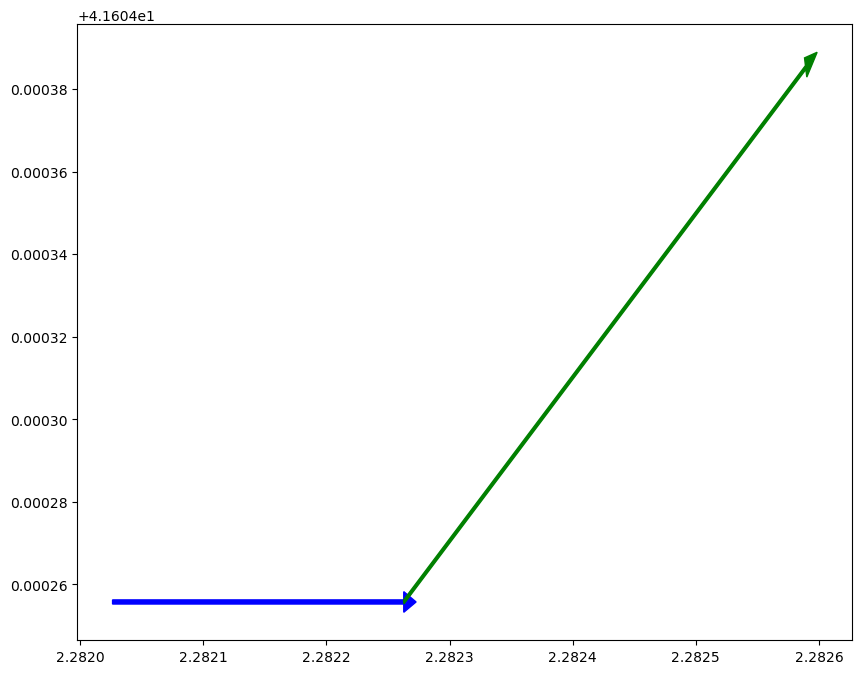

In [40]:
fig, ax = plt.subplots(figsize=(10,8)) 


lat1=41.604255693213176
lon1=2.2820262810539305

lat2=41.60425569448399
lon2=2.2822627757834932

lat3=41.604385210964
lon3=2.2825892046794545

a1 = orientation(lat1,lon1,lat2,lon2)
a2 = orientation(lat2,lon2,lat3,lon3)
reo1 = reorientation(a1,a2)

print('The blue vector have an orientation of {:.0f}º with respect to the North'.format(a1))
print('The green vector have an orientation of {:.0f}º with respect to the North'.format(a2))
print('The change in orientation from blue to green is: {:.0f}º'.format(reo1))

ax.arrow(lon1,lat1,lon2-lon1,lat2-lat1,color='blue',head_width=0.000005,head_length=0.00001, width=0.000001)
ax.arrow(lon2,lat2,lon3-lon2,lat3-lat2,color='green',head_width=0.000005,head_length=0.00001, width=0.000001)

plt.show()



#### Example 2

The orange vector have an orientation of 265º with respect to the North
The black vector have an orientation of 75º with respect to the North
The change in orientation from orange to black is: 170º


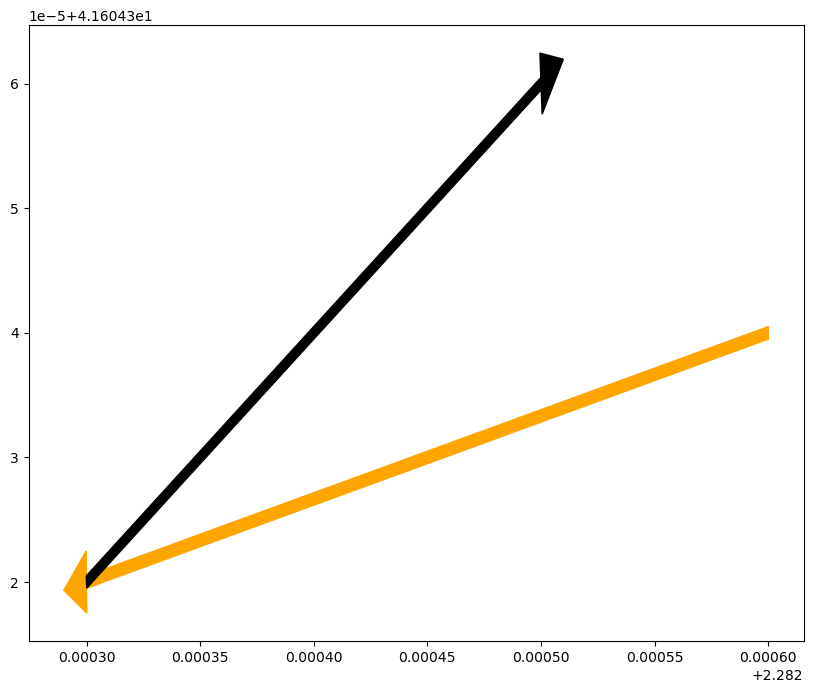

In [39]:
fig, ax = plt.subplots(figsize=(10,8)) 

lat4=41.60434
lon4=2.2826

lat5=41.60432
lon5=2.2823

lat6=41.60436
lon6=2.2825


a3 = orientation(lat4,lon4,lat5,lon5)
a4 = orientation(lat5,lon5,lat6,lon6)
reo2 = reorientation(a3,a4)
print('The orange vector have an orientation of {:.0f}º with respect to the North'.format(a3))
print('The black vector have an orientation of {:.0f}º with respect to the North'.format(a4))
print('The change in orientation from orange to black is: {:.0f}º'.format(reo2))

ax.arrow(lon4,lat4,lon5-lon4,lat5-lat4,color='orange',head_width=0.000005,head_length=0.00001, width=0.000001)
ax.arrow(lon5,lat5,lon6-lon5,lat6-lat5,color='black',head_width=0.000005,head_length=0.00001, width=0.000001)

plt.show()

#### Using the GPS data

##### Orientation

In [15]:
latitudes = df2['lat'].tolist()   # Latitudes and longitudes to lists
longitudes = df2['lon'].tolist()

orientations=[]
for i in range(1,len(latitudes)):
    orientations.append(orientation(latitudes[i-1], longitudes[i-1], latitudes[i], longitudes[i]))

orientations.insert(len(orientations), np.nan)  # Insert last element as NaN in order to add to the Data-Frame
df2['orientation'] = orientations  # New column

##### Reorientation

In [16]:
reorientations=[]
for i in range(1,len(orientations)):
    reorientations.append(reorientation(orientations[i-1],orientations[i]))

# Insert last element NaN in order to add to the Data-Frame
reorientations.insert(len(reorientations), np.nan)  

df2['reorientation'] = reorientations  # New column

## 3.4. Detecting stops

The Wikiloc App. stops recording the geo-locations when it considers that there is no movement. After some tests using several trajectories, we consider that when the time difference between two consecutive recordings is larger than 10 seconds, the participant (device) is stopped. 

We therefore can label each GPS location as "stop" or "moving".

Of course, this step (and the threshold chosen of 10 seconds) will totally depend on the app. we are using to collect the GPS mobility data.

In [17]:
def stops(times):
    """ Given a list of time increments between consecutive records, this function labels each record as stop if the next
        record is collected after 10 or more seconds, or moving otherwise.
        
        Inputs:
            - List of consecutive time increments
        
        Outputs:
            - List of strings (stop or moving)
    """

    stops=[]                       # New column labelling each geo-location as "stop" if the time difference is >10s. or "flight"
    for i in range(len(times)):
        if df2['At'][i]>=10.0:
            stops.append('stop')
        else:
            stops.append('moving')
            
    return stops

time_increments = df2['At'][:-1].tolist()
labels_stops = stops(time_increments)

labels_stops.insert(len(labels_stops), 'stop')  # Insert last element as "stop" to add as a new column of the data-frame

df2['stops']=labels_stops  # Add the new column with the stops     


# 4. Save processed dataset

After processing the data-set, cleaning up the trajectory and performing some basic calculations between GPS records, we can save the data-set in a new .csv file

First, we remove those columns we don't need. In this example, the column "index", "cmt" and "desc" are removed. 

In [18]:
# Delete unnecessary columns
del df2['index']
del df2['cmt']
del df2['desc']

# Save to csv (if we don't specify the path, the .csv is saved at the same folder as the notebook)
df2.to_csv('processed data\\g5.csv',index=False)